In [10]:
import pandas as pd
import os
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/John-Blodgett/CSC466-Project/main/total_data.csv')
# df = df.drop('file dist of bytes', axis=1)
df['hash dist'] = df['hash dist'].apply(eval)
df['file dist of bytes'] = df['file dist of bytes'].apply(eval)
df_dist = pd.DataFrame(df['hash dist'].to_list(), 
                       index=df.index, 
                       columns=['0','1','2','3','4','5','6','7','8','9','a','b','c','d','e','f'])
df_dist['hash type'] = df['hash type']

df.append(df_dist)
df.drop(['hash dist', 'hash'], axis=1, inplace=True)

df[['consecutiveCount', 'file size (bytes)']] = StandardScaler().fit_transform(df[['consecutiveCount', 'file size (bytes)']])

df = pd.get_dummies(df, columns=['file type', 'consecutiveByte'])

df

,file dist of bytes,consecutiveCount,hash type,hash len,hash 0 bits,hash 1 bits,hash len bits,file size (bytes),file type_.jpg,file type_.json,file type_.pdf,file type_.txt,"consecutiveByte_b""'""",consecutiveByte_b' ',consecutiveByte_b'!',"consecutiveByte_b'""'",consecutiveByte_b'(',consecutiveByte_b'-',consecutiveByte_b'.',consecutiveByte_b'0',consecutiveByte_b'1',consecutiveByte_b'2',consecutiveByte_b'3',consecutiveByte_b'4',consecutiveByte_b'5',consecutiveByte_b'6',consecutiveByte_b'7',consecutiveByte_b'8',consecutiveByte_b'9',consecutiveByte_b';',consecutiveByte_b'>',consecutiveByte_b'?',consecutiveByte_b'@',consecutiveByte_b'A',consecutiveByte_b'B',consecutiveByte_b'D',consecutiveByte_b'O',consecutiveByte_b'P',consecutiveByte_b'Q',consecutiveByte_b'U',...,consecutiveByte_b'\x11',consecutiveByte_b'\x14',consecutiveByte_b'\x16',consecutiveByte_b'\x1a',consecutiveByte_b'\x1e',consecutiveByte_b'\x82',consecutiveByte_b'\x83',consecutiveByte_b'\x84',consecutiveByte_b'\x88',consecutiveByte_b'\x8a',consecutiveByte_b'\x8f',consecutiveByte_b'\x91',consecutiveByte_b'\x92',consecutiveByte_b'\x9e',consecutiveByte_b'\xa3',consecutiveByte_b'\xa4',consecutiveByte_b'\xa5',consecutiveByte_b'\xaa',consecutiveByte_b'\xb3',consecutiveByte_b'\xd1',consecutiveByte_b'\xdd',consecutiveByte_b'\xe7',consecutiveByte_b'\xee',consecutiveByte_b'\xf4',consecutiveByte_b'\xf5',consecutiveByte_b'\xff',consecutiveByte_b'_',consecutiveByte_b'a',consecutiveByte_b'b',consecutiveByte_b'c',consecutiveByte_b'd',consecutiveByte_b'e',consecutiveByte_b'f',consecutiveByte_b'h',consecutiveByte_b'i',consecutiveByte_b'o',consecutiveByte_b'p',consecutiveByte_b's',consecutiveByte_b'w',consecutiveByte_b'~'
0,"[185, 71, 61, 64, 62, 43, 59, 58, 47, 49, 108,...",-0.079771,SHA-1,40,69,91,160,-0.226642,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"[192, 78, 55, 54, 53, 54, 61, 70, 50, 55, 115,...",-0.079771,SHA-256,64,133,123,256,-0.226927,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"[181, 80, 57, 57, 63, 60, 63, 70, 44, 44, 115,...",-0.079771,SHA-3-256,64,116,140,256,-0.226016,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"[215, 68, 51, 73, 52, 57, 52, 55, 40, 43, 102,...",-0.079771,MD5,32,55,73,128,-0.226521,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"[191, 90, 60, 66, 56, 59, 66, 60, 53, 54, 102,...",-0.079771,SHA-256,64,117,139,256,-0.226609,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5245,"[10194, 3869, 3826, 3705, 3466, 3743, 3592, 38...",-0.061607,SHA-256,64,125,131,256,0.140832,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5246,"[29855, 14763, 15433, 17860, 14182, 15818, 156...",0.175344,SHA-256,64,134,122,256,1.485487,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5247,"[3220, 3164, 3107, 3076, 3088, 3066, 3136, 319...",-0.038490,SHA-256,64,121,135,256,0.238327,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5248,"[1053, 896, 765, 76

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('hash type', axis=1), df['hash type'], test_size=0.2, random_state=0)

# reduce dimensionality of file byte dist (from 256 to around 2 or whatever happens to capture 90% of the variance)
X_train_file_dist = pd.DataFrame(X_train['file dist of bytes'].to_list(),  index=X_train.index)
X_test_file_dist = pd.DataFrame(X_test['file dist of bytes'].to_list(),  index=X_test.index)

scaler = StandardScaler()
scaler.fit(X_train_file_dist)
X_train_file_dist = pd.DataFrame(scaler.transform(X_train_file_dist), index=X_train.index)
X_test_file_dist = pd.DataFrame(scaler.transform(X_test_file_dist), index=X_test.index)

pca = PCA(0.90)
pcs = pca.fit(X_train_file_dist)
# fix this to do x columns not hardcoded 2
X_train_file_dist = pd.DataFrame(pca.transform(X_train_file_dist), index=X_train.index, 
                                 columns=['file dist pca ' + str(i+1) for i in range(len(pca.explained_variance_))])
X_test_file_dist = pd.DataFrame(pca.transform(X_test_file_dist), index=X_test.index,
                                columns=['file dist pca ' + str(i+1) for i in range(len(pca.explained_variance_))])

X_train = X_train.join(X_train_file_dist)
X_train.drop('file dist of bytes', axis=1, inplace=True)
X_test = X_test.join(X_test_file_dist)
X_test.drop('file dist of bytes', axis=1, inplace=True)

In [ ]:
def get_cv_error_knn(k):
  print(k)
  # define pipeline
  pipeline = make_pipeline(
      KNeighborsClassifier(n_neighbors=k)
  )
  # calculate errors from cross-validation
  cv_errs = cross_val_score(pipeline, X=X_train, 
                             y=y_train,
                             scoring='accuracy', cv=10)
  # calculate average of the cross-validation errors
  return cv_errs.mean()

get_cv_error_knn(6)

0.7490476190476191

7     0.743333
12    0.745952
10    0.746190
1     0.746905
8     0.748571
9     0.748810
6     0.749048
5     0.749286
2     0.750476
11    0.750952
14    0.752381
4     0.753333
13    0.755000
16    0.755238
3     0.755714
15    0.757619
17    0.759524
18    0.760000
19    0.764762
dtype: float64

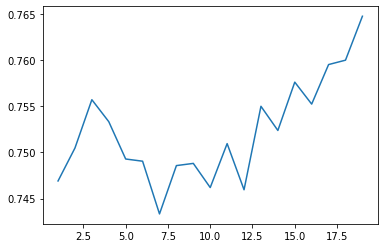

In [ ]:
vals = pd.Series(range(1, 20), index=range(1, 20))
test_errs = vals.apply(get_cv_error_knn)

test_errs.plot.line()
test_errs.sort_values()

In [ ]:
best_knn = KNeighborsClassifier(n_neighbors=19)
best_knn.fit(X_train, y_train)

y_pred = best_knn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         MD5       1.00      1.00      1.00       251
       SHA-1       1.00      1.00      1.00       269
     SHA-256       0.51      0.47      0.49       265
   SHA-3-256       0.51      0.55      0.53       265

    accuracy                           0.75      1050
   macro avg       0.75      0.75      0.75      1050
weighted avg       0.75      0.75      0.75      1050



In [ ]:
def get_cv_error_mlp_iterations(k):
  print(k)
  # define pipeline
  pipeline = make_pipeline(
      MLPClassifier(max_iter=k)
  )
  # calculate errors from cross-validation
  cv_errs = cross_val_score(pipeline, X=X_train, 
                             y=y_train,
                             scoring='f1_macro', cv=10)
  # calculate average of the cross-validation errors
  return cv_errs.mean()

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


100    0.685757
300    0.687934
200    0.698743
400    0.709340
dtype: float64

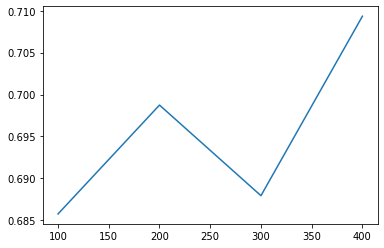

In [ ]:
vals = pd.Series(range(100, 600, 100), index=range(100, 600, 100))
test_errs = vals.apply(get_cv_error_mlp_iterations)

test_errs.plot.line()
test_errs.sort_values()

In [ ]:
def get_cv_error_mlp_hidden_layers(k):
  print(k)
  # define pipeline
  pipeline = make_pipeline(
      MLPClassifier(hidden_layer_sizes=k, max_iter=300)
  )
  # calculate errors from cross-validation
  cv_errs = cross_val_score(pipeline, X=X_train, 
                             y=y_train,
                             scoring='f1_macro', cv=10)
  # calculate average of the cross-validation errors
  return cv_errs.mean()

125    0.685177
150    0.691012
175    0.703397
200    0.709649
225    0.716691
100    0.721213
dtype: float64

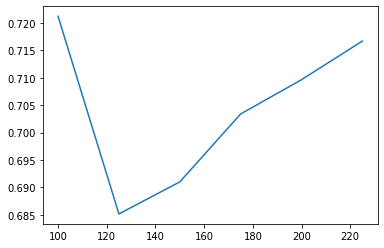

In [ ]:
vals = pd.Series(range(100, 250, 25), index=range(100, 250, 25))
test_errs = vals.apply(get_cv_error_mlp_hidden_layers)

test_errs.plot.line()
test_errs.sort_values()

In [ ]:
best_mlp = MLPClassifier(max_iter=500)
best_mlp.fit(X_train, y_train)


y_pred = best_mlp.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         MD5       1.00      0.98      0.99       251
       SHA-1       0.98      0.99      0.98       269
     SHA-256       0.50      0.73      0.60       265
   SHA-3-256       0.51      0.28      0.36       265

    accuracy                           0.74      1050
   macro avg       0.75      0.74      0.73      1050
weighted avg       0.74      0.74      0.73      1050



In [ ]:
def get_cv_error_descision_tree_maxDepth(k):
  print(k)
  # define pipeline
  pipeline = make_pipeline(
      DecisionTreeClassifier(max_depth=k)
  )
  # calculate errors from cross-validation
  cv_errs = cross_val_score(pipeline, X=X_train, 
                             y=y_train,
                             scoring='f1_macro', cv=10)
  # calculate average of the cross-validation errors
  return cv_errs.mean()

6     0.720636
5     0.725834
8     0.731518
7     0.732396
13    0.739056
15    0.739534
12    0.739924
11    0.740474
16    0.740579
18    0.740672
14    0.741480
22    0.742514
10    0.742667
20    0.742799
23    0.743806
29    0.743880
24    0.744000
9     0.744558
21    0.746198
30    0.746374
26    0.747238
17    0.747311
19    0.748031
25    0.749672
27    0.750685
28    0.750885
dtype: float64

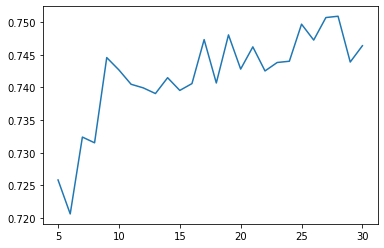

In [ ]:
vals = pd.Series(range(5,31), index=range(5,31))
test_errs = vals.apply(get_cv_error_descision_tree_maxDepth)

test_errs.plot.line()
test_errs.sort_values()

In [ ]:
def get_cv_error_descision_tree_maxFeatures(k):
  print(k)
  # define pipeline
  pipeline = make_pipeline(
      DecisionTreeClassifier(max_features=k)
  )
  # calculate errors from cross-validation
  cv_errs = cross_val_score(pipeline, X=X_train, 
                             y=y_train,
                             scoring='f1_macro', cv=10)
  # calculate average of the cross-validation errors
  return cv_errs.mean()

3     0.724003
6     0.727115
4     0.727867
5     0.728279
2     0.737358
9     0.739052
12    0.739223
11    0.739329
7     0.739628
14    0.740812
13    0.743263
8     0.743490
10    0.744010
15    0.745247
dtype: float64

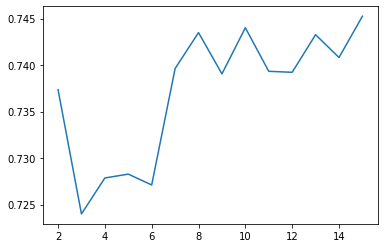

In [ ]:
vals = pd.Series(range(2,16), index=range(2,16))
test_errs = vals.apply(get_cv_error_descision_tree_maxFeatures)

test_errs.plot.line()
test_errs.sort_values()

In [ ]:
best_tree = DecisionTreeClassifier(max_depth=28)
best_tree.fit(X_train, y_train)


y_pred = best_tree.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         MD5       1.00      1.00      1.00       251
       SHA-1       1.00      1.00      1.00       269
     SHA-256       0.50      0.47      0.49       265
   SHA-3-256       0.50      0.53      0.51       265

    accuracy                           0.75      1050
   macro avg       0.75      0.75      0.75      1050
weighted avg       0.75      0.75      0.75      1050



In [ ]:
def get_cv_error_gbc_max_depth(n):
  print(n)
  # define pipeline
  pipeline = make_pipeline(
      GradientBoostingClassifier(max_depth=n)
  )
  # calculate errors from cross-validation
  cv_errs = cross_val_score(pipeline, X=X_train, 
                             y=y_train,
                             scoring='f1_macro', cv=10)
  # calculate average of the cross-validation errors
  return cv_errs.mean()

18    0.741623
17    0.742803
13    0.743944
7     0.744618
20    0.744909
19    0.745147
12    0.745515
15    0.745689
11    0.745802
9     0.745922
14    0.746422
16    0.746736
10    0.747753
5     0.748450
6     0.749750
8     0.749890
dtype: float64

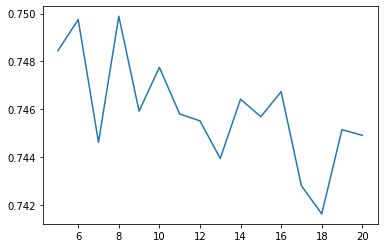

In [ ]:
vals = pd.Series(range(5,21), index=range(5,21))
test_errs = vals.apply(get_cv_error_gbc_max_depth)

test_errs.plot.line()
test_errs.sort_values()

In [ ]:
def get_cv_error_gbc_max_features(n):
  print(n)
  # define pipeline
  pipeline = make_pipeline(
      GradientBoostingClassifier(max_features=n)
  )
  # calculate errors from cross-validation
  cv_errs = cross_val_score(pipeline, X=X_train, 
                             y=y_train,
                             scoring='f1_macro', cv=10)
  # calculate average of the cross-validation errors
  return cv_errs.mean()

6     0.751774
7     0.752648
4     0.755810
5     0.756674
9     0.756698
2     0.757360
3     0.759263
10    0.760141
8     0.760597
dtype: float64

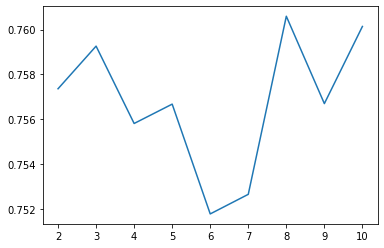

In [ ]:
vals = pd.Series(range(2,11), index=range(2,11))
test_errs = vals.apply(get_cv_error_gbc_max_features)

test_errs.plot.line()
test_errs.sort_values()

In [ ]:
best_gbc = GradientBoostingClassifier(max_features=8, )
best_gbc.fit(X_train, y_train)


y_pred = best_gbc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         MD5       1.00      1.00      1.00       251
       SHA-1       1.00      1.00      1.00       269
     SHA-256       0.51      0.41      0.46       265
   SHA-3-256       0.51      0.61      0.56       265

    accuracy                           0.75      1050
   macro avg       0.76      0.76      0.75      1050
weighted avg       0.75      0.75      0.75      1050



In [ ]:
def get_cv_error_random_forest_estimators(k):
  print(k)
  # define pipeline
  pipeline = make_pipeline(
      RandomForestClassifier(n_estimators=k)
  )
  # calculate errors from cBhaluezpz123@ross-validation
  cv_errs = cross_val_score(pipeline, X=X_train, 
                             y=y_train,
                             scoring='f1_macro', cv=10)
  # calculate average of the cross-validation errors
  return cv_errs.mean()

1000    0.744401
1400    0.744694
1600    0.745927
400     0.746443
1800    0.746630
1200    0.746856
600     0.747323
800     0.747817
200     0.747938
dtype: float64

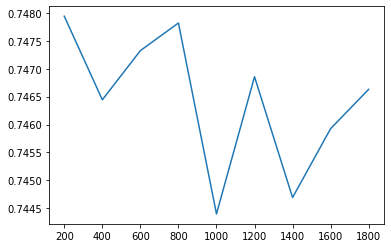

In [ ]:
vals = pd.Series(range(200,2000,200), index=range(200,2000,200))
test_errs = vals.apply(get_cv_error_random_forest_estimators)

test_errs.plot.line()
test_errs.sort_values()

In [ ]:
def get_cv_error_random_forest_depth(k):
  print(k)
  # define pipeline
  pipeline = make_pipeline(
      RandomForestClassifier(max_depth=k)
  )
  # calculate errors from cBhaluezpz123@ross-validation
  cv_errs = cross_val_score(pipeline, X=X_train, 
                             y=y_train,
                             scoring='f1_macro', cv=10)
  # calculate average of the cross-validation errors
  return cv_errs.mean()

20    0.738351
90    0.740237
40    0.741504
80    0.742705
70    0.743423
30    0.743925
60    0.743984
50    0.747079
10    0.759665
dtype: float64

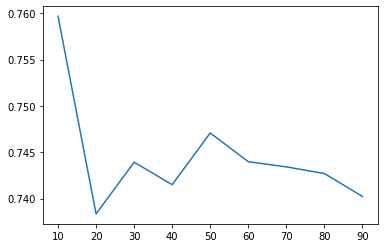

In [ ]:
vals = pd.Series(range(10,100,10), index=range(10,100,10))
test_errs = vals.apply(get_cv_error_random_forest_depth)

test_errs.plot.line()
test_errs.sort_values()

In [ ]:
best_rf = RandomForestClassifier(max_depth=10, n_estimators=800)
best_rf.fit(X_train, y_train)


y_pred = best_rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         MD5       1.00      1.00      1.00       251
       SHA-1       1.00      1.00      1.00       269
     SHA-256       0.51      0.38      0.44       265
   SHA-3-256       0.51      0.64      0.57       265

    accuracy                           0.75      1050
   macro avg       0.76      0.75      0.75      1050
weighted avg       0.75      0.75      0.75      1050



In [ ]:
def get_cv_error_Ada_boost(n):
  print(n)
  # define pipeline
  pipeline = make_pipeline(
      AdaBoostClassifier(learning_rate=n, random_state=0)
  )
  # calculate errors from cross-validation
  cv_errs = cross_val_score(pipeline, X=X_train, 
                             y=y_train,
                             scoring='f1_macro', cv=10)
  # calculate average of the cross-validation errors
  return cv_errs.mean()

8     0.332955
15    0.336569
5     0.470043
6     0.663417
7     0.663417
9     0.663597
4     0.667843
10    0.669119
11    0.669119
12    0.669119
13    0.669119
14    0.669119
1     0.669456
3     0.671891
2     0.705226
dtype: float64

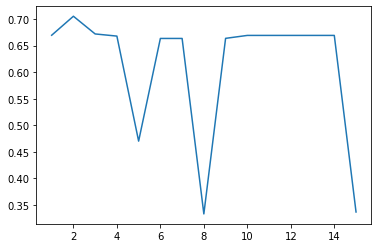

In [ ]:
vals = pd.Series(range(1,16), index=range(1,16))
test_errs = vals.apply(get_cv_error_Ada_boost)

test_errs.plot.line()
test_errs.sort_values()

In [ ]:
best_ada = AdaBoostClassifier(learning_rate=2)
best_ada.fit(X_train, y_train)


y_pred = best_ada.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         MD5       1.00      1.00      1.00       251
       SHA-1       1.00      1.00      1.00       269
     SHA-256       0.50      0.78      0.61       265
   SHA-3-256       0.50      0.22      0.31       265

    accuracy                           0.75      1050
   macro avg       0.75      0.75      0.73      1050
weighted avg       0.75      0.75      0.73      1050



# Picking an Algorithm and Further Fine Tuning

Most of the machine learning algorithms we used, after the pca components and scaling, resulted in the same results (for accuracy, f1score, etc). They hovered around 0.74 for reasons described below. We decided to pick the KNeighborsClassifier since it was relatively simple/fast to train and intuitively understand, and decided to further tune it.

In [7]:
def get_cv_error_knn(k, p, features=None):
  print(k, p)
  pipeline = make_pipeline(
      KNeighborsClassifier(n_neighbors=k, p=p)
  )

  if features != None:
    cv_errs = cross_val_score(pipeline, X=X_train[features], 
                              y=y_train,
                              scoring='accuracy', cv=10)
  else:
    cv_errs = cross_val_score(pipeline, X=X_train, 
                              y=y_train,
                              scoring='accuracy', cv=10)
    
  return cv_errs.mean()

1 2
2 2
3 2
4 2
5 2
6 2
7 2
8 2
9 2
10 2
11 2
12 2
13 2
14 2
15 2
16 2
17 2
18 2
19 2
20 2
21 2
22 2
23 2
24 2
25 2
26 2
27 2
28 2
29 2
30 2


7     0.743333
12    0.745952
10    0.746190
1     0.746905
8     0.748571
9     0.748810
6     0.749048
5     0.749286
2     0.750476
11    0.750952
14    0.752381
4     0.753333
13    0.755000
16    0.755238
3     0.755714
23    0.756905
15    0.757619
17    0.759524
27    0.759762
18    0.760000
30    0.760238
21    0.760476
28    0.760714
26    0.760952
25    0.761429
24    0.762381
29    0.762619
22    0.763095
19    0.764762
20    0.764762
dtype: float64

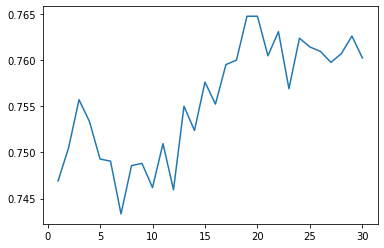

In [15]:
k_vals = {}
for i in range(1,31):
  k_vals[i] = get_cv_error_knn(i, 2)

test_errs_kvals = pd.Series(k_vals)

test_errs_kvals.plot.line()
test_errs_kvals.sort_values()

19 2
19 3
19 4
19 5
19 6
19 7
19 8
19 9
19 10


10    0.757619
7     0.759524
8     0.759524
9     0.759762
6     0.761905
5     0.762381
3     0.762857
2     0.764762
4     0.764762
dtype: float64

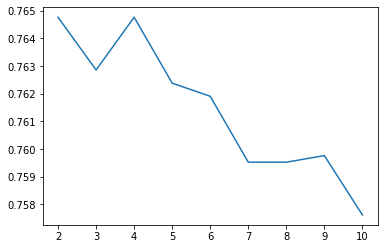

In [16]:
p_vals = {}
for i in range(2,11):
  p_vals[i] = get_cv_error_knn(test_errs_kvals.idxmax(),i)

test_errs_pvals = pd.Series(p_vals)

test_errs_pvals.plot.line()
test_errs_pvals.sort_values()

In [68]:
best_knn = KNeighborsClassifier(n_neighbors=test_errs_kvals.idxmax(), p=test_errs_pvals.idxmax())
best_knn.fit(X_train, y_train)

y_pred = best_knn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         MD5       1.00      1.00      1.00       251
       SHA-1       1.00      1.00      1.00       269
     SHA-256       0.51      0.47      0.49       265
   SHA-3-256       0.51      0.55      0.53       265

    accuracy                           0.75      1050
   macro avg       0.75      0.75      0.75      1050
weighted avg       0.75      0.75      0.75      1050



In [69]:
classification_report(y_test, y_pred, output_dict=True)

{'MD5': {'f1-score': 1.0, 'precision': 1.0, 'recall': 1.0, 'support': 251},
 'SHA-1': {'f1-score': 0.9981378026070763,
  'precision': 1.0,
  'recall': 0.9962825278810409,
  'support': 269},
 'SHA-256': {'f1-score': 0.48722986247544203,
  'precision': 0.5081967213114754,
  'recall': 0.4679245283018868,
  'support': 265},
 'SHA-3-256': {'f1-score': 0.5253623188405796,
  'precision': 0.5052264808362369,
  'recall': 0.5471698113207547,
  'support': 265},
 'accuracy': 0.7504761904761905,
 'macro avg': {'f1-score': 0.7526824959807744,
  'precision': 0.7533558005369281,
  'recall': 0.7528442168759206,
  'support': 1050},
 'weighted avg': {'f1-score': 0.7503199970952851,
  'precision': 0.7510068081610893,
  'recall': 0.7504761904761905,
  'support': 1050}}

Rather than doing standard feature selection, we decided to run permutation based feature importance on the full model above and remove the features that were least important iteratively until we arrived at a final reduced model.

In [70]:
r = permutation_importance(best_knn, X_test, y_test, n_repeats=3)
r

{'importances': array([[ 0.00857143,  0.00857143,  0.00666667],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.11809524,  0.10761905,  0.12380952],
        [ 0.13047619,  0.12      ,  0.11809524],
        [ 0.50761905,  0.50952381,  0.48095238],
        [-0.00095238,  0.00095238,  0.00190476],
        [ 0.00190476, -0.00095238, -0.00285714],
        [-0.00380952, -0.00380952, -0.0047619 ],
        [-0.00285714,  0.00380952,  0.0047619 ],
        [ 0.00952381,  0.00095238,  0.00285714],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.0047619 ,  0.00095238,  0.0047619 ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [-0.00380952, -0.00285714, -0.00190476],
        [-0.00095238, -0.00095238,  0.        ],
        [ 0.00095238,  0.00095238,  0.00190476],
     

In [71]:
cols = []
for i in r.importances_mean.argsort()[::-1]:
  if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
    print(f"{X_train.columns[i]:<8}"
    f"{r.importances_mean[i]:.3f}"
    f" +/- {r.importances_std[i]:.3f}")
    cols.append(i)

hash len bits0.499 +/- 0.013
hash 1 bits0.123 +/- 0.005
hash 0 bits0.117 +/- 0.007
consecutiveCount0.008 +/- 0.001
consecutiveByte_b'\x01'0.005 +/- 0.001
consecutiveByte_b'\n'0.004 +/- 0.001
consecutiveByte_b'\x00'0.002 +/- 0.000
consecutiveByte_b'2'0.001 +/- 0.000
consecutiveByte_b'6'0.001 +/- 0.000


So, we should include those features (and features related to them, like common dummy variables) in the reduced model.

In [82]:
cols = list(set(cols).union(set(range(10,91))))
X_train.columns[cols]

Index(['consecutiveCount', 'hash 0 bits', 'hash 1 bits', 'hash len bits',
       'consecutiveByte_b"'"', 'consecutiveByte_b' '', 'consecutiveByte_b'!'',
       'consecutiveByte_b'"'', 'consecutiveByte_b'('', 'consecutiveByte_b'-'',
       'consecutiveByte_b'.'', 'consecutiveByte_b'0'', 'consecutiveByte_b'1'',
       'consecutiveByte_b'2'', 'consecutiveByte_b'3'', 'consecutiveByte_b'4'',
       'consecutiveByte_b'5'', 'consecutiveByte_b'6'', 'consecutiveByte_b'7'',
       'consecutiveByte_b'8'', 'consecutiveByte_b'9'', 'consecutiveByte_b';'',
       'consecutiveByte_b'>'', 'consecutiveByte_b'?'', 'consecutiveByte_b'@'',
       'consecutiveByte_b'A'', 'consecutiveByte_b'B'', 'consecutiveByte_b'D'',
       'consecutiveByte_b'O'', 'consecutiveByte_b'P'', 'consecutiveByte_b'Q'',
       'consecutiveByte_b'U'', 'consecutiveByte_b'Y'', 'consecutiveByte_b'\\'',
       'consecutiveByte_b'\n'', 'consecutiveByte_b'\r'',
       'consecutiveByte_b'\x00'', 'consecutiveByte_b'\x01'',
       'consecuti

In [83]:
X_train2 = X_train.iloc[:, cols]
X_test2 = X_test.iloc[:, cols]

best_knn = KNeighborsClassifier(n_neighbors=test_errs_kvals.idxmax(), p=test_errs_pvals.idxmax())
best_knn.fit(X_train2, y_train)

y_pred = best_knn.predict(X_test2)
classification_report(y_test, y_pred, output_dict=True)

{'MD5': {'f1-score': 1.0, 'precision': 1.0, 'recall': 1.0, 'support': 251},
 'SHA-1': {'f1-score': 1.0, 'precision': 1.0, 'recall': 1.0, 'support': 269},
 'SHA-256': {'f1-score': 0.5028790786948176,
  'precision': 0.51171875,
  'recall': 0.49433962264150944,
  'support': 265},
 'SHA-3-256': {'f1-score': 0.5194805194805195,
  'precision': 0.5109489051094891,
  'recall': 0.5283018867924528,
  'support': 265},
 'accuracy': 0.7533333333333333,
 'macro avg': {'f1-score': 0.7555898995438344,
  'precision': 0.7556669137773723,
  'recall': 0.7556603773584906,
  'support': 1050},
 'weighted avg': {'f1-score': 0.7532621843013946,
  'precision': 0.7533399320038234,
  'recall': 0.7533333333333333,
  'support': 1050}}

This actually increased our F-1 score while having less features! Definitely better than the previous model. Running feature importance again:

In [87]:
r = permutation_importance(best_knn, X_test2, y_test, n_repeats=3)

cols = []
for i in r.importances_mean.argsort()[::-1]:
  if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
    print(f"{X_train2.columns[i]:<8}"
    f"{r.importances_mean[i]:.3f}"
    f" +/- {r.importances_std[i]:.3f}")
    cols.append(i)

hash 1 bits0.497 +/- 0.005
hash 0 bits0.136 +/- 0.002
hash len0.130 +/- 0.002
consecutiveByte_b'0'0.001 +/- 0.000


It seems like all the features mentioned earlier are still significant. Therefore, we have found our most reduced model. As an aside, let's see what would happen in 2 cases: (a) where we include the PCA components, and (b) where our model only includes the length of the hash.

In [98]:
X_train3 = X_train2.join(X_train.iloc[:, [91,92]])
X_test3 = X_test2.join(X_test.iloc[:, [91,92]])

best_knn = KNeighborsClassifier(n_neighbors=test_errs_kvals.idxmax(), p=test_errs_pvals.idxmax())
best_knn.fit(X_train3, y_train)

y_pred = best_knn.predict(X_test3)
classification_report(y_test, y_pred, output_dict=True)

{'MD5': {'f1-score': 1.0, 'precision': 1.0, 'recall': 1.0, 'support': 251},
 'SHA-1': {'f1-score': 0.9981378026070763,
  'precision': 1.0,
  'recall': 0.9962825278810409,
  'support': 269},
 'SHA-256': {'f1-score': 0.4881889763779528,
  'precision': 0.5102880658436214,
  'recall': 0.4679245283018868,
  'support': 265},
 'SHA-3-256': {'f1-score': 0.5280289330922242,
  'precision': 0.5069444444444444,
  'recall': 0.5509433962264151,
  'support': 265},
 'accuracy': 0.7514285714285714,
 'macro avg': {'f1-score': 0.7535889280193133,
  'precision': 0.7543081275720165,
  'recall': 0.7537876131023357,
  'support': 1050},
 'weighted avg': {'f1-score': 0.7512350618199052,
  'precision': 0.7519682049774643,
  'recall': 0.7514285714285714,
  'support': 1050}}

Adding the principal components of the file distribution of bytes leads to a slightly lower f-1 score. Even if the decrease is insignificant, we prefer models with less features, so the earlier model is still better.

In [99]:
X_train4 = X_train[['hash len']]
X_test4 = X_test[['hash len']]

best_knn = KNeighborsClassifier(n_neighbors=test_errs_kvals.idxmax(), p=test_errs_pvals.idxmax())
best_knn.fit(X_train4, y_train)

y_pred = best_knn.predict(X_test4)
classification_report(y_test, y_pred, output_dict=True)

{'MD5': {'f1-score': 1.0, 'precision': 1.0, 'recall': 1.0, 'support': 251},
 'SHA-1': {'f1-score': 1.0, 'precision': 1.0, 'recall': 1.0, 'support': 269},
 'SHA-256': {'f1-score': 0.6666666666666666,
  'precision': 0.5,
  'recall': 1.0,
  'support': 265},
 'SHA-3-256': {'f1-score': 0.0,
  'precision': 0.0,
  'recall': 0.0,
  'support': 265},
 'accuracy': 0.7476190476190476,
 'macro avg': {'f1-score': 0.6666666666666666,
  'precision': 0.625,
  'recall': 0.75,
  'support': 1050},
 'weighted avg': {'f1-score': 0.6634920634920635,
  'precision': 0.6214285714285714,
  'recall': 0.7476190476190476,
  'support': 1050}}

Predicting only on the hash length significantly decreases the f1-score. Therefore, only predicting on the hash length does not yield an appropriate model.

Finally, we consider how much better our model does than a model which would randomly guess:

In [100]:
final_knn = KNeighborsClassifier(n_neighbors=test_errs_kvals.idxmax(), p=test_errs_pvals.idxmax())
final_knn.fit(X_train2, y_train)

y_pred = final_knn.predict(X_test2)
classification_report(y_test, y_pred, output_dict=True)

{'MD5': {'f1-score': 1.0, 'precision': 1.0, 'recall': 1.0, 'support': 251},
 'SHA-1': {'f1-score': 1.0, 'precision': 1.0, 'recall': 1.0, 'support': 269},
 'SHA-256': {'f1-score': 0.5028790786948176,
  'precision': 0.51171875,
  'recall': 0.49433962264150944,
  'support': 265},
 'SHA-3-256': {'f1-score': 0.5194805194805195,
  'precision': 0.5109489051094891,
  'recall': 0.5283018867924528,
  'support': 265},
 'accuracy': 0.7533333333333333,
 'macro avg': {'f1-score': 0.7555898995438344,
  'precision': 0.7556669137773723,
  'recall': 0.7556603773584906,
  'support': 1050},
 'weighted avg': {'f1-score': 0.7532621843013946,
  'precision': 0.7533399320038234,
  'recall': 0.7533333333333333,
  'support': 1050}}

In [101]:
y_test.value_counts(normalize=True)

SHA-1        0.256190
SHA-256      0.252381
SHA-3-256    0.252381
MD5          0.239048
Name: hash type, dtype: float64

In [102]:
X_train2

,consecutiveCount,hash 0 bits,hash 1 bits,hash len bits,"consecutiveByte_b""'""",consecutiveByte_b' ',consecutiveByte_b'!',"consecutiveByte_b'""'",consecutiveByte_b'(',consecutiveByte_b'-',consecutiveByte_b'.',consecutiveByte_b'0',consecutiveByte_b'1',consecutiveByte_b'2',consecutiveByte_b'3',consecutiveByte_b'4',consecutiveByte_b'5',consecutiveByte_b'6',consecutiveByte_b'7',consecutiveByte_b'8',consecutiveByte_b'9',consecutiveByte_b';',consecutiveByte_b'>',consecutiveByte_b'?',consecutiveByte_b'@',consecutiveByte_b'A',consecutiveByte_b'B',consecutiveByte_b'D',consecutiveByte_b'O',consecutiveByte_b'P',consecutiveByte_b'Q',consecutiveByte_b'U',consecutiveByte_b'Y',consecutiveByte_b'\\',consecutiveByte_b'\n',consecutiveByte_b'\r',consecutiveByte_b'\x00',consecutiveByte_b'\x01',consecutiveByte_b'\x02',consecutiveByte_b'\x03',...,consecutiveByte_b'\x11',consecutiveByte_b'\x14',consecutiveByte_b'\x16',consecutiveByte_b'\x1a',consecutiveByte_b'\x1e',consecutiveByte_b'\x82',consecutiveByte_b'\x83',consecutiveByte_b'\x84',consecutiveByte_b'\x88',consecutiveByte_b'\x8a',consecutiveByte_b'\x8f',consecutiveByte_b'\x91',consecutiveByte_b'\x92',consecutiveByte_b'\x9e',consecutiveByte_b'\xa3',consecutiveByte_b'\xa4',consecutiveByte_b'\xa5',consecutiveByte_b'\xaa',consecutiveByte_b'\xb3',consecutiveByte_b'\xd1',consecutiveByte_b'\xdd',consecutiveByte_b'\xe7',consecutiveByte_b'\xee',consecutiveByte_b'\xf4',consecutiveByte_b'\xf5',consecutiveByte_b'\xff',consecutiveByte_b'_',consecutiveByte_b'a',consecutiveByte_b'b',consecutiveByte_b'c',consecutiveByte_b'd',consecutiveByte_b'e',consecutiveByte_b'f',consecutiveByte_b'h',consecutiveByte_b'i',consecutiveByte_b'o',consecutiveByte_b'p',consecutiveByte_b's',consecutiveByte_b'w',consecutiveByte_b'~'
3471,-0.113621,130,126,256,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3484,-0.115272,75,85,160,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
771,-0.067387,61,67,128,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4994,-0.118575,141,115,256,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4838,0.988575,78,82,160,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4931,-0.038490,122,134,256,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3264,-0.113621,68,60,128,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1653,-0.067387,130,126,256,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2607,-0.118575,126,130,256,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


The highest accuracy you could attain with a model that chooses randomly is 0.256190. Our final model has an f-1 score of 0.7555898995438344, which is much better than the randomized model.

However, it is important to note that our final model mostly takes into account the hash length (in bits), the number of 0 bits, and the number of 1 bits. Thus, it is mostly leveraging the distinct hash lengths of the various algorithms to predict the hash. However, there is a slgiht contribution from the consecutive byte value and consecutive byte count features, which indicates that there might be a "periodic" nature in the hash algorithm that our model was able to pick up on. Interestingly, the file size, file type, etc. were not essential features. These results, and more, are expanded upon and interpreted further in our report.

Therefore, given that we are predicting mostly on the number of total/0/1 bits in the hash, we determine that hash algorithms are MOSTLY secure. However, the other features indicate further work that could be done with respect to identifying hash algorithms. This is once again expanded in the report.